# Assignment 5: Actor-Critic With Two Neural Networks

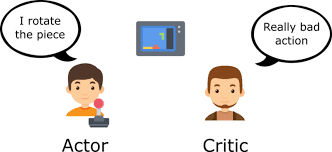

In this assignment, you will be completing the loss functions and Pytorch gradient updates for the one-step and batch Actor-Critic algorithms.

The baseline environment is Cartpole-v0. Get your agent to learn this task (at least somewhat), and then test out the algorithms on two other environments from this list:

* MountainCarContinuous-v0
* Pendulum-v0
* Acrobot-v1

How do they perform? Create plots to show your work and use a text cell to describe what you find. 

When you are finished, simply save your notebook and submit it on OWL.

MountainCarContinuous-v0

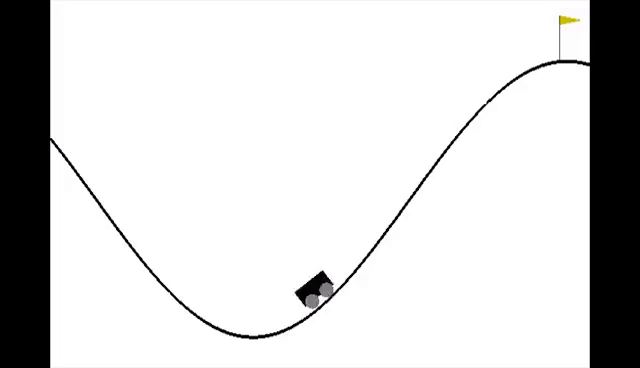

Acrobot-v1:

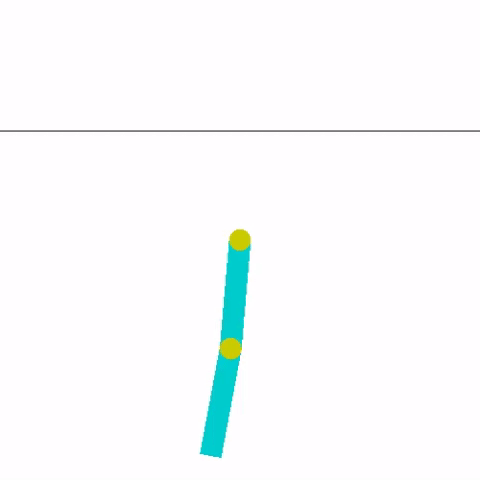

Pendulum-v0:

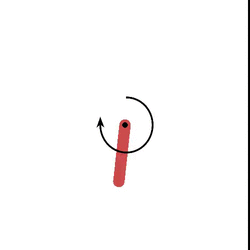

Cartpole-v0

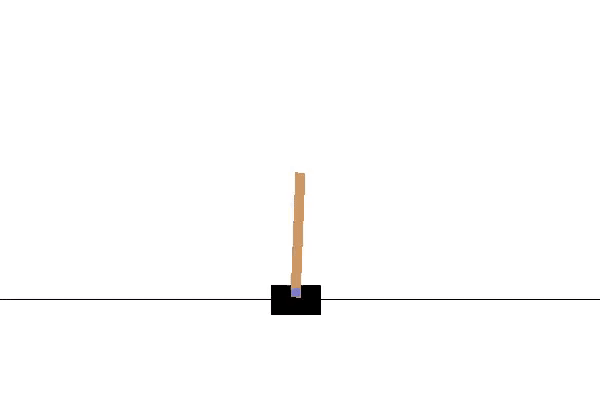

The Actor-Critic architecture we will be using is pictured below. We have:

1. An Actor or 'Policy Network' that estimates action probabilities."Which action should I take?"
2. A Critic or 'Value Network' that takes in a state and outputs a value. "How good is the place I'll end up?"

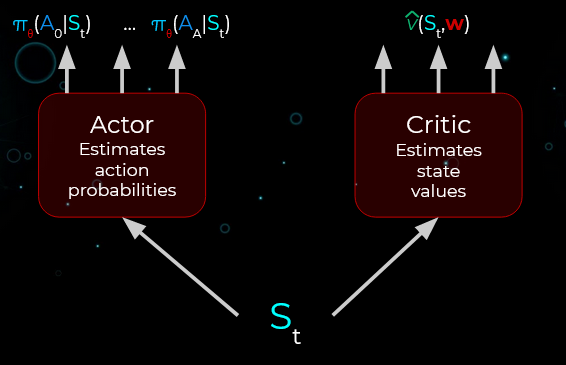

## Part 1: One-Step Actor-Critic

The information you need to complete the update function is below:

1. The policy cost function:

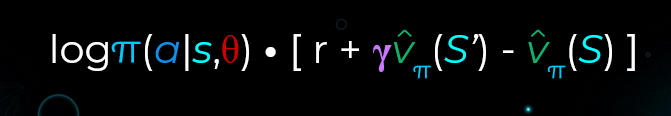

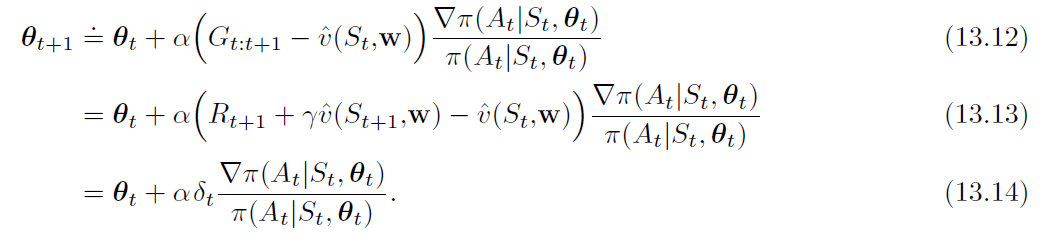

Note that the gradient uses the log probability of choosing the action A_t. That is, because we are taking the derivative w.r.t the log probability, and pytorch is set up to automatically calculate the gradient of the loss, we make the log probability the loss and achieve what we need: 

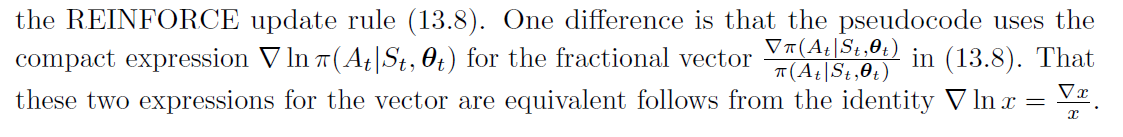

2. The algorithm itself (NOTE: you do not need to use the identity matrix):

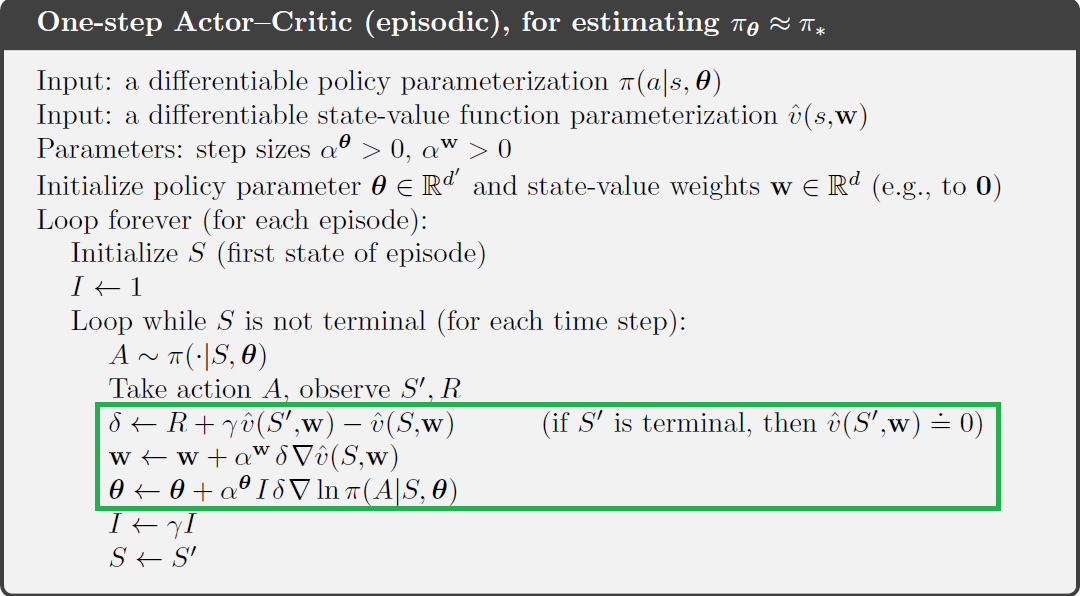

3. Use squared loss for the critic.

4. Pytorch computes the gradients for you as long as you calculate the loss. Use the code snippet below as a reference and review [this webpage](https://pytorch.org/docs/stable/optim.html). Don't forget that you have two optimizers! And don't overlook the fact that Pytorch optimizers want to *minimize*, so you want to use the *negative* log probability of choosing an action.

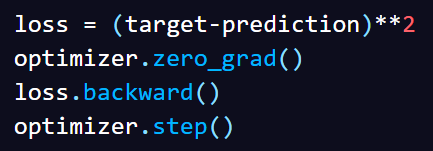

5. You will need to use the .detach() method on your delta tensor when you compute the actor loss. If you don't the underlying computation graph generated by pytorch will try to run backprop on the same tensor twice, which gives a potentially very confusing error. 

For a brief review of Pytorch computation graphs and gradient computation, see [this useful blog post](http://www.bnikolic.co.uk/blog/pytorch-detach.html). 

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torch.distributions import Categorical
from itertools import count
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
env = gym.make("CartPole-v0")

In [4]:
class Actor(nn.Module):
    """
    Feel free to change the architecture for different tasks!
    """
    def __init__(self, env):
        super(Actor, self).__init__()
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, self.action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        # Note the conversion to Pytorch distribution.
        distribution = Categorical(F.softmax(output, dim=-1)) 
        return distribution


class Critic(nn.Module):
    """
    Feel free to change the architecture for different tasks!
    """
    def __init__(self, env):
        super(Critic, self).__init__()
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1) # Note the single value - this is V(s)!

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

class ActorCritic_OneStep():

  def __init__(self, env, actor_lr, critic_lr, gamma):
    self.env = env
    self.actor = Actor(env)
    self.critic = Critic(env)
    self.actor_lr = actor_lr
    self.critic_lr = critic_lr
    self.optim_actor = optim.Adam(self.actor.parameters(), lr = self.actor_lr)
    self.optim_critic = optim.Adam(self.critic.parameters(), lr = self.critic_lr)
    self.gamma = gamma
  
  def update(self, log_prob, delta):
    ####### YOUR CODE IN HERE #######
    actor_loss=-(log_prob)*delta.detach()
    critic_loss=delta**2
    self.optim_actor.zero_grad()
    self.optim_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    self.optim_actor.step()
    self.optim_critic.step()



    #################################

  def learn_task(self, n_episodes):

    episode_rewards = []
    avg_rewards = []

    for episode in tqdm( range(n_episodes) ):
        state = env.reset()
        rewards = []
        state = torch.FloatTensor(state).to(device)

        for i in count():

            dist, value = self.actor(state), self.critic(state)
            action = dist.sample() # We sample an action index from our softmax (multinomial) distribution.
            next_state, reward, done, _ = env.step(action.cpu().numpy()) # gym does not like Pytorch Tensors
            rewards.append(reward)

            next_state = torch.FloatTensor(next_state).to(device)
            next_value = self.critic(next_state)
            log_prob = dist.log_prob(action).unsqueeze(0)
            
            
            if done:
                next_value = torch.tensor([0]).float().unsqueeze(0).to(device)
                delta= reward + self.gamma*next_value - value
                self.update(log_prob, delta)
                episode_rewards.append(i)
                break
           
            delta= reward + self.gamma*next_value - value
            self.update(log_prob, delta) 

            state = next_state

        if episode >= 100:
          avg_rewards.append(np.mean(episode_rewards[-100:]))
          if avg_rewards[-1] >= 195:
            print("Solved on episode ",episode)
            return episode_rewards, avg_rewards

    return episode_rewards, avg_rewards

In [5]:
agent = ActorCritic_OneStep(env, .0005, .0005, .99)

In [6]:
rew, avg = agent.learn_task(n_episodes = 1000)

100%|██████████| 1000/1000 [09:34<00:00,  1.74it/s]


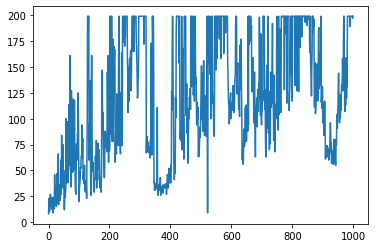

In [7]:
plt.plot(rew)

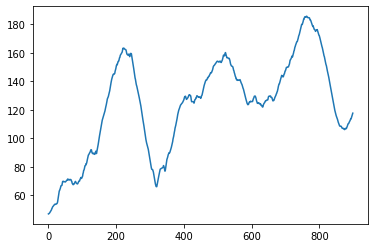

In [8]:
plt.plot(avg)

## Part 2: Batch Actor-Critic

In practice, we see that one-step methods tend to perform relatively poorly compared to batch methods. This is very similar to supervised learning, where we always use batches. The batch method can be seen in multiple models in the stablebaselines3 library.

In batch methods, the loss functions become like this:

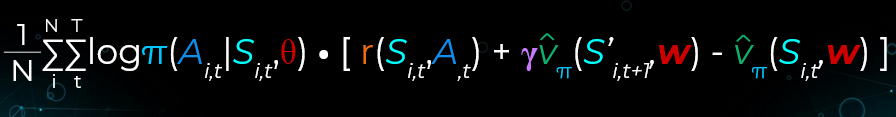

Where N is the number of samples in the batch. 

However, **there is something we can do to eliminate the bias of this function:**

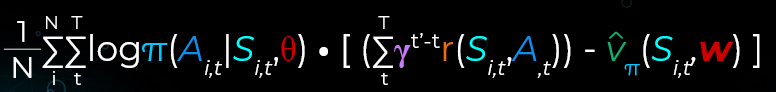



By using this loss function for the actor and its counterpart for the critic, we keep the lower variance of bootstrapping (i.e., the use of v(s')-v(s)) while **completely eliminating its problematic bias**. Amazing. 

Coupled with the desirable learning properties of batch updates, we can significantly improve our agent's ability to learn.

For this activity you'll want to record the relevant values in lists. You can convert lists to Pytorch tensors using [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html), e.g.:



```
returns = torch.cat(returns).detach()
```



Don't forget to:
- Use the negative log probability. 
- Use .detach() for the delta ("advantage") tensor when calculating the actor loss, otherwise the graph will do backprop on it twice over (once for actor, once for critic). 

In [9]:
class ActorCritic_Batch():

  def __init__(self, env, actor_lr, critic_lr, gamma):
    self.env = env
    self.actor = Actor(env)
    self.critic = Critic(env)
    self.actor_lr = actor_lr
    self.critic_lr = critic_lr
    self.optim_actor = optim.Adam(self.actor.parameters(), lr = self.actor_lr)
    self.optim_critic = optim.Adam(self.critic.parameters(), lr = self.critic_lr)
    self.gamma = gamma
  
  def update(self, actor_loss, critic_loss):
    self.optim_actor.zero_grad()
    self.optim_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    self.optim_actor.step()
    self.optim_critic.step()
  

  def compute_returns(self, next_value, rewards, masks):
    
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + self.gamma * R * masks[step]
        returns.insert(0, R)
    return returns

  def learn_task(self, n_episodes):

    episode_rewards = []
    avg_rewards = []



    for episode in tqdm( range(n_episodes) ):
        state = self.env.reset()
        rewards = []
        masks=[]
        log_probs=[]
        values=[]
    

        for i in count():
            state = torch.FloatTensor(state).to(device)
            dist, value = self.actor(state), self.critic(state)
            action = dist.sample() # We sample an action index from our softmax (multinomial) distribution.
            next_state, reward, done, _ = self.env.step(action.cpu().numpy()) # gym does not like Pytorch Tensors
            log_prob = dist.log_prob(action).unsqueeze(0)
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
            masks.append(torch.tensor([1-done], dtype=torch.float, device=device))
            
            if done:
                ep_return = np.sum(rewards)
                episode_rewards.append(ep_return) 
                break
            state = next_state

        next_state = torch.FloatTensor(next_state).to(device)
        next_value = self.critic(next_state)
        returns = self.compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        delta = returns - values
        actor_loss = torch.mean(-(log_probs * delta.detach()))
        critic_loss = torch.mean(delta.pow(2))
        self.update(actor_loss,critic_loss)

        if episode >= 100:
          avg_rewards.append(torch.mean(torch.stack(episode_rewards[-100:])))
          if avg_rewards[-1] >= 195:
            print("Solved on episode ",episode)
            return episode_rewards, avg_rewards

    return episode_rewards, avg_rewards

In [10]:
agent1 = ActorCritic_Batch(env, .0005, .0005, .99)

In [11]:
rew1, avg1 = agent1.learn_task(n_episodes = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out

Solved on episode  277


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


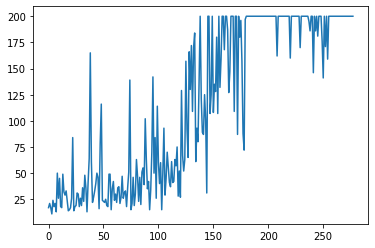

In [12]:
plt.plot(rew1)

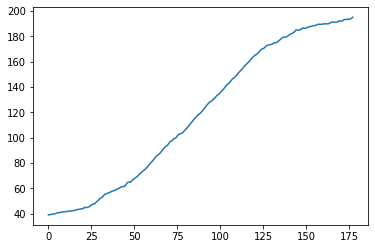

In [13]:
plt.plot(avg1)

## Part 3: Experiment!

Test out batch Actor-Critic on two other environments from this list:

* MountainCarContinuous-v0
* Pendulum-v0
* Acrobot-v1

How do they perform? Create plots to show your work (as I have above) and use a text cell to describe what you find. Feel free to experiment with a couple different architectures (or even use optuna to find a very good one!). 

1) MountainCarContinuous-v0

In [59]:
env2 = gym.make("MountainCarContinuous-v0")

In [60]:
env2.observation_space.shape[0]

2

In [61]:
env2.action_space

Box(-1.0, 1.0, (1,), float32)

In [62]:
class Actor(nn.Module):
    """
    Feel free to change the architecture for different tasks!
    """
    def __init__(self, env):
        super(Actor, self).__init__()
        self.state_size = env.observation_space.shape[0]
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 2)

        
    def forward(self, state):

        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        x =   self.linear3(output)


        # Note the conversion to Pytorch distribution.
        # distribution = Categorical(F.softmax(output, dim=-1)) 
        return x


class Critic(nn.Module):
    """
    Feel free to change the architecture for different tasks!
    """
    def __init__(self, env):
        super(Critic, self).__init__()
        self.state_size = env.observation_space.shape[0]
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1) # Note the single value - this is V(s)!

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

In [160]:
class ActorCritic_Batch():

  def __init__(self, env, actor_lr, critic_lr, gamma):
    self.env = env
    self.actor = Actor(env)
    self.critic = Critic(env)
    self.actor_lr = actor_lr
    self.critic_lr = critic_lr
    self.optim_actor = optim.Adam(self.actor.parameters(), lr = self.actor_lr)
    self.optim_critic = optim.Adam(self.critic.parameters(), lr = self.critic_lr)
    self.gamma = gamma
  
  def update(self, actor_loss, critic_loss):
    self.optim_actor.zero_grad()
    self.optim_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    self.optim_actor.step()
    self.optim_critic.step()
  

  def compute_returns(self, next_value, rewards, masks):
    
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + self.gamma * R * masks[step]
        returns.insert(0, R)
    return returns

  def learn_task(self, n_episodes):

    episode_rewards = []
    avg_rewards = []
    self.env._max_episode_steps =200


    for episode in tqdm( range(n_episodes) ):
        state = self.env.reset()
        rewards = []
        masks=[]
        log_probs=[]
        values=[]
    

        for i in count():
            state = torch.FloatTensor(state).to(device)
            # dist, value = self.actor(state), self.critic(state)
            # action = dist.sample() # We sample an action index from our softmax (multinomial) distribution.
            value = self.critic(state)
            mu, sigma  = self.actor.forward(state)
            sigma = torch.exp(sigma)
            action_probs = torch.distributions.Normal(mu, sigma)        #creating a normal distribution of action probabilities
            probs = action_probs.sample(sample_shape=torch.Size([1]))   #sampling the action from action probablities
            log_prob = action_probs.log_prob(probs).to(device)
            action = (torch.tanh(probs)).item()               #to clip the action to (-1,1)
            action = np.array(action).reshape((1,))
            next_state, reward, done, _ = self.env.step(action) # gym does not like Pytorch Tensors
            # log_prob = dist.log_prob(action).unsqueeze(0)
            
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
            masks.append(torch.tensor([1-done], dtype=torch.float, device=device))
            
            if done:
                ep_return = np.sum(rewards)
                # print(ep_return)
                episode_rewards.append(ep_return) 
                break
            state = next_state

        next_state = torch.FloatTensor(next_state).to(device)
        next_value = self.critic(next_state)
        returns = self.compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        delta = returns - values
        # print(delta)
        actor_loss = -(log_probs * delta.detach()).mean()
        critic_loss = (delta**2).mean()

        # print(actor_loss)
        # print(critic_loss)

        self.update(actor_loss,critic_loss)

        if episode >= 100:
          avg_rewards.append(torch.mean(torch.stack(episode_rewards[-100:])))
          if avg_rewards[-1] >= 90:
            print("Solved on episode ",episode)
            return episode_rewards, avg_rewards

    return episode_rewards, avg_rewards

In [64]:
agent2 = ActorCritic_Batch(env2, .0001, .0001, .99)

In [65]:
rew2, avg2 = agent2.learn_task(n_episodes = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


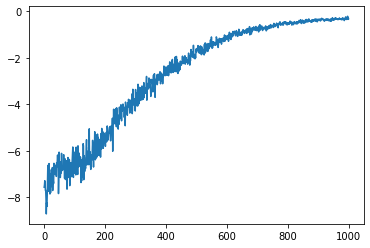

In [66]:
plt.plot(rew2)

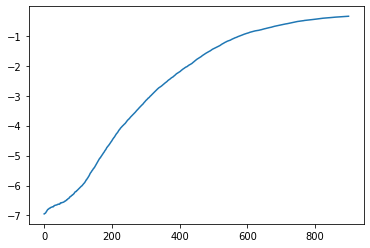

In [67]:
plt.plot(avg2)

2) Acrobot v1

In [265]:
env3 = gym.make("Acrobot-v1")

In [266]:
env3.action_space.n

3

In [267]:
env3.observation_space.shape[0]

6

In [268]:
class Actor(nn.Module):
    """
    Feel free to change the architecture for different tasks!
    """
    def __init__(self, env):
        super(Actor, self).__init__()
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.linear1 = nn.Linear(self.state_size, 32)
        self.linear2 = nn.Linear(32, 64)
        self.linear3 = nn.Linear(64, 128)
        self.linear4 = nn.Linear(128, 256)
        self.linear5 = nn.Linear(256, 512)
        self.linear6 = nn.Linear(512, self.action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = F.relu(self.linear3(output))
        output = F.relu(self.linear4(output))
        output = F.relu(self.linear5(output))
        output = self.linear6(output)
        # Note the conversion to Pytorch distribution.
        distribution = Categorical(F.softmax(output, dim=-1)) 
        return distribution


class Critic(nn.Module):
    """
    Feel free to change the architecture for different tasks!
    """
    def __init__(self, env):
        super(Critic, self).__init__()
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.linear1 = nn.Linear(self.state_size, 32)
        self.linear2 = nn.Linear(32, 64)
        self.linear3 = nn.Linear(64, 128)
        self.linear4 = nn.Linear(128, 256)
        self.linear5 = nn.Linear(256, 512)
        self.linear6 = nn.Linear(512, 1) # Note the single value - this is V(s)!


    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = F.relu(self.linear3(output))
        output = F.relu(self.linear4(output))
        output = F.relu(self.linear5(output))
        value = self.linear6(output)
        return value

In [269]:
class ActorCritic_Batch():

  def __init__(self, env, actor_lr, critic_lr, gamma):
    self.env = env
    self.actor = Actor(env)
    self.critic = Critic(env)
    self.actor_lr = actor_lr
    self.critic_lr = critic_lr
    self.optim_actor = optim.Adam(self.actor.parameters(), lr = self.actor_lr)
    self.optim_critic = optim.Adam(self.critic.parameters(), lr = self.critic_lr)
    self.gamma = gamma
  
  def update(self, actor_loss, critic_loss):
    self.optim_actor.zero_grad()
    self.optim_critic.zero_grad()
    (actor_loss+critic_loss).backward()
    # critic_loss.backward()
    self.optim_actor.step()
    self.optim_critic.step()
  

  def compute_returns(self, next_value, rewards, masks):
    
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + self.gamma * R * masks[step]
        returns.insert(0, R)
    return returns

  def learn_task(self, n_episodes):

    episode_rewards = []
    avg_rewards = []
    # self.env._max_episode_steps=1000
    


    for episode in tqdm( range(n_episodes) ):
        state = self.env.reset()
        rewards = []
        masks=[]
        log_probs=[]
        values=[]
    

        for i in count():
            state = torch.FloatTensor(state).to(device)
            dist, value = self.actor(state), self.critic(state)
            action = dist.sample() # We sample an action index from our softmax (multinomial) distribution.
            next_state, reward, done, _ = self.env.step(action.cpu().numpy()) # gym does not like Pytorch Tensors
            log_prob = dist.log_prob(action).unsqueeze(0)
            log_probs.append(log_prob)


            # if done and i < env._max_episode_steps:
            #   reward = 100
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
            masks.append(torch.tensor([1-done], dtype=torch.float, device=device))
    
            if done:
                ep_return = np.sum(rewards)
                # print(ep_return)
                episode_rewards.append(ep_return) 
                break
            state = next_state

        next_state = torch.FloatTensor(next_state).to(device)
        next_value = self.critic(next_state)
        returns = self.compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        delta = returns - values
        actor_loss = -(log_probs * delta.detach()).mean()
        critic_loss = (delta**2).mean()
        # print(actor_loss+critic_loss)
        # print(critic_loss)
        self.update(actor_loss,critic_loss)

        if episode >= 10:
          avg_rewards.append(torch.mean(torch.stack(episode_rewards[-100:])))
          if avg_rewards[-1] >= -60:
            print("Solved on episode ",episode)
            return episode_rewards, avg_rewards

    return episode_rewards, avg_rewards

In [270]:
agent3 = ActorCritic_Batch(env3, .001, .001, .99)

In [271]:
rew3, avg3 = agent3.learn_task(n_episodes = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


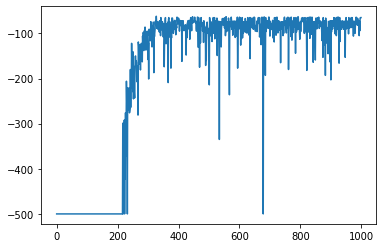

In [272]:
plt.plot(rew3)

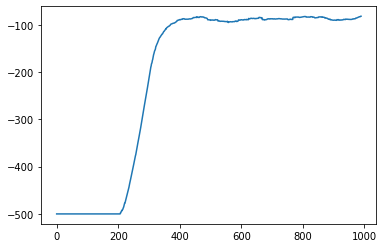

In [273]:
plt.plot(avg3)

FIndings

1) For the Mountaincarcontinous-v0 problem, I changed the output size of the actor network to 2. These 2 outputs were mu and sigma respectively. As we know the environment accepts an action that is in the range of (-1,+1), I created a distribution using mu and sigma, which will sample an action between the given range. The idea is to get different values of mu and sigma by decreasing the loss through backpropagation. The actor-critic batch performs considerably well in the environment. As we can see from the curve, it manages to reduce the cumulative rewards in an episode starting from -8 to almost 0. However, it does not get over the 0 thresholds. This is probably because the car never achieves the target of reaching the top and getting a +100 reward. Hence, the model's primary objective is to reduce the overall negative reward, which it does by not taking actions of large magnitude.
________________________________________
2) For the Acrobot v1, I first used the same architecture as the one used for the cartpole, however, it did not learn at all and I got a flat line curve at -500 reward(-1*length of an episode without success). Then I changed the network architecture and changed the learning rate as well. As we can see from the plot, for the first 200 episodes, the curve remains flat line across -500, however, after that, it starts to learn. Similar to the mountaincar, the model tries to reduce the overall negative rewards instead of achieving the ultimate goal and getting a higher reward. Hence, we can see the curve becomes stable again around -100 reward.
________________________________________
3) In both cases, the actor-critic model tries to reduce the overall negative reward instead of reaching the goal and achieving a higher reward. This looks like a drawback of the actor-critic algorithm, where once it finds a way to minimize negative reward, it sticks to it and does not explore the option of getting the highest possible reward by achieving the final goal.
